In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [107]:
df = pd.read_csv('data_wsen.csv')
df.head()

,Title,authorVal,authorMod,authorKarma,Num_Comments,subredditVal,Subreddit_Subcribers,Score,Ratio,NSFW,...,Class_love,Class_nervousness,Class_optimism,Class_pride,Class_realization,Class_relief,Class_remorse,Class_sadness,Class_suprise,Class_neutral
0,Open Ameritrade Buy Question,ftoledo,0.0,14,3.0,WallStreetbetsELITE,499719.0,1.0,1.00,0.0,...,0.027922,0.012384,0.030525,0.012625,0.023377,0.016472,0.039398,0.056775,0.031668,0.105605
1,Fuses have me confused...,eeyore134,0.0,21742,2.0,virtualpinball,11526.0,2.0,1.00,0.0,...,0.024714,0.005187,0.014965,0.004392,0.012675,0.005491,0.007280,0.013266,0.013262,0.192386
2,Legit check?,MattisGai,1.0,10720,4.0,bapeheads,31006.0,3.0,0.71,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,brocante rue de bretagne in november?,legsfordaysss,0.0,884,0.0,paris,364919.0,1.0,1.00,0.0,...,0.039824,0.006173,0.023703,0.007602,0.016182,0.009648,0.015850,0.022776,0.020582,0.086709
4,What is the Best Burger in OC,pxrking11,0.0,93,125.0,orangecounty,378170.0,52.0,0.90,0.0,...,0.056375,0.014495,0.039951,0.019795,0.025123,0.016429,0.030830,0.045656,0.027279,0.087232


In [108]:
# print(df.columns)

df = df.drop(['Title'],axis=1)
df = df.drop(['authorVal'],axis=1)
df = df.drop(['Text_Named_Entities'],axis=1)
df = df.drop(['MediaEmbed'],axis=1)
df = df.drop(['SecureMediaEmbed'],axis=1)
df = df.drop(['Media'],axis=1)
df = df.drop(['Text'],axis=1)
# df = df.drop(['Num_Comments'],axis=1)


#probably noramized score depends on score so will drop for now  (and to double check with group)
df = df.drop(['Normalized_Score'],axis=1)

#Now we want to do a hot econding of the Day_of_Week column 
df = pd.get_dummies(df, columns=['Day_of_Week'], drop_first=True, dtype=int)

#Also want to do a hot encoding of the 'Media_Type' column
df = pd.get_dummies(df, columns=['Media_Type'], drop_first=True, dtype=int)

#now want to change the "Created_UTC" column data from 
df['Created_UTC'] = pd.to_datetime(df['Created_UTC'])

#for 'Created_UTC' column will extract the year, month, day, hour, minute, second then drop the original column
df['Year'] = df['Created_UTC'].dt.year
df['Month'] = df['Created_UTC'].dt.month
df['Day'] = df['Created_UTC'].dt.day
df['Hour'] = df['Created_UTC'].dt.hour
df['Minute'] = df['Created_UTC'].dt.minute
df['Second'] = df['Created_UTC'].dt.second
df = df.drop(['Created_UTC'],axis=1)

#'Has_Media' column is boolean so will convert to int
df['Has_Media'] = df['Has_Media'].astype(int)

#'Awards' column looks like crap so will drop
df = df.drop(['Awards'],axis=1)

# 'Subreddit_Popularity' to int
popularity_mapping = {'Low': 1, 'Medium': 2, 'High': 3}
df['Subreddit_Popularity'] = df['Subreddit_Popularity'].map(popularity_mapping)

# 'subredditVal' to freq (float)
freq_mapping = df['subredditVal'].value_counts(normalize=True)
df['subredditVal'] = df['subredditVal'].map(freq_mapping)


#'Enagement_Rate' has infinite values so will drop for now
#df = df.drop(['Engagement_Rate'],axis=1)



# Convert all columns in the DataFrame to numeric, coercing invalid entries to NaN
df = df.apply(pd.to_numeric, errors='coerce')

df = df.dropna(subset=['Score'])
print(df['Score'].isna().sum())

print(df.columns)
df.head()

# print(df['Day_of_Week_Sunday'].dtypes)


0
Index(['authorMod', 'authorKarma', 'Num_Comments', 'subredditVal',
       'Subreddit_Subcribers', 'Score', 'Ratio', 'NSFW', 'Spoiler',
       'Hour_of_Day', 'Is_Weekend', 'Title_Character_Count',
       'Title_Word_Diversity', 'Title_Punctuation_Count', 'Title_Has_Question',
       'Title_Named_Entities', 'Text_Character_Count', 'Text_Word_Diversity',
       'Text_Punctuation_Count', 'Text_Has_Question', 'Has_Media',
       'Engagement_Rate', 'Is_Popular_Subreddit', 'Subreddit_Popularity',
       'Class_admiration', 'Class_amusment', 'Class_anger', 'Class_annoyance',
       'Class_approval', 'Class_caring', 'Class_confusion', 'Class_curiousity',
       'Class_desire', 'Class_dissapointment', 'Class_disaproval',
       'Class_disgust', 'Class_embarrassment', 'Class_excitement',
       'Class_fear', 'Class_gratitude', 'Class_grief', 'Class_joy',
       'Class_love', 'Class_nervousness', 'Class_optimism', 'Class_pride',
       'Class_realization', 'Class_relief', 'Class_remorse', 'Class

,authorMod,authorKarma,Num_Comments,subredditVal,Subreddit_Subcribers,Score,Ratio,NSFW,Spoiler,Hour_of_Day,...,Day_of_Week_Tuesday,Day_of_Week_Wednesday,Media_Type_none,Media_Type_video,Year,Month,Day,Hour,Minute,Second
0,0.0,14,3.0,0.000280,499719.0,1.0,1.00,0.0,0.0,11.0,...,0,0,1,0,2021.0,2.0,1.0,11.0,21.0,48.0
1,0.0,21742,2.0,0.000093,11526.0,2.0,1.00,0.0,0.0,23.0,...,0,1,1,0,2024.0,10.0,2.0,23.0,57.0,11.0
2,1.0,10720,4.0,0.000280,31006.0,3.0,0.71,0.0,0.0,10.0,...,0,0,1,0,2024.0,10.0,19.0,10.0,40.0,21.0
3,0.0,884,0.0,0.000467,364919.0,1.0,1.00,0.0,0.0,22.0,...,0,0,1,0,2024.0,8.0,25.0,22.0,31.0,46.0
4,0.0,93,125.0,0.000187,378170.0,52.0,0.90,0.0,0.0,21.0,...,0,0,1,0,2022.0,1.0,14.0,21.0,15.0,32.0


In [128]:
X = df.drop(['Num_Comments', 'Score'],axis=1)
print(X.columns)
# X = df.drop(['Score'],axis=1)
y_score = df['Score']
y_com = df['Num_Comments']
X_score_train, X_score_test, y_score_train, y_score_test = train_test_split(X, y_score, test_size=0.2, random_state=42)
X_com_train, X_com_test, y_com_train, y_com_test = train_test_split(X, y_com, test_size=0.2, random_state=42)

Index(['authorMod', 'authorKarma', 'subredditVal', 'Subreddit_Subcribers',
       'Ratio', 'NSFW', 'Spoiler', 'Hour_of_Day', 'Is_Weekend',
       'Title_Character_Count', 'Title_Word_Diversity',
       'Title_Punctuation_Count', 'Title_Has_Question', 'Title_Named_Entities',
       'Text_Character_Count', 'Text_Word_Diversity', 'Text_Punctuation_Count',
       'Text_Has_Question', 'Has_Media', 'Engagement_Rate',
       'Is_Popular_Subreddit', 'Subreddit_Popularity', 'Class_admiration',
       'Class_amusment', 'Class_anger', 'Class_annoyance', 'Class_approval',
       'Class_caring', 'Class_confusion', 'Class_curiousity', 'Class_desire',
       'Class_dissapointment', 'Class_disaproval', 'Class_disgust',
       'Class_embarrassment', 'Class_excitement', 'Class_fear',
       'Class_gratitude', 'Class_grief', 'Class_joy', 'Class_love',
       'Class_nervousness', 'Class_optimism', 'Class_pride',
       'Class_realization', 'Class_relief', 'Class_remorse', 'Class_sadness',
       'Class_su

In [129]:
X_train, X_test, y_train, y_test = X_score_train, X_score_test, y_score_train, y_score_test

# Replace infinite values with NaN
X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan


# #impute nan values with mean
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# k = 15 
# selector = SelectKBest(score_func=f_regression, k=k)
# X_train_selected = selector.fit_transform(X_train, y_train)
# X_test_selected = selector.transform(X_test)

# selected_features = X.columns[selector.get_support()]
# print("Selected Features:", list(selected_features))

Selected Features: ['authorMod', 'authorKarma', 'Num_Comments', 'subredditVal', 'Subreddit_Subcribers', 'Title_Punctuation_Count', 'Title_Has_Question', 'Text_Word_Diversity', 'Text_Has_Question', 'Is_Popular_Subreddit', 'Subreddit_Popularity', 'Day_of_Week_Monday', 'Day_of_Week_Saturday', 'Year', 'Minute']


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {"n_estimators": [100, 300, 500],
          "learning_rate": [0.01, 0.05, 0.1, 0.5, 1],
          "random_state": [42]
          }

model = XGBRegressor()
grid_search = GridSearchCV(model, param_grid=param_grid)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
# model.set_params(**grid_search.best_params_)

{'learning_rate': 0.01, 'n_estimators': 100, 'random_state': 42}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [130]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    random_state=42,
    objective='reg:squarederror',
    # early_stopping_rounds=50
)

evals_result = {}
# model.fit(X_train_selected, y_train)
model.fit(X_train, y_train, 
          eval_set=[(X_train, y_train), (X_val, y_val)])
evals_result = model.evals_result()

[0]	validation_0-rmse:16963.97920	validation_1-rmse:17078.57720
[1]	validation_0-rmse:16170.79000	validation_1-rmse:16294.60059
[2]	validation_0-rmse:15415.50495	validation_1-rmse:15546.72976
[3]	validation_0-rmse:14695.96895	validation_1-rmse:14837.58105
[4]	validation_0-rmse:14010.44899	validation_1-rmse:14164.57664
[5]	validation_0-rmse:13357.40807	validation_1-rmse:13526.58162
[6]	validation_0-rmse:12735.32054	validation_1-rmse:12922.49325
[7]	validation_0-rmse:12142.73795	validation_1-rmse:12350.79854
[8]	validation_0-rmse:11578.15679	validation_1-rmse:11808.20026
[9]	validation_0-rmse:11040.30287	validation_1-rmse:11294.78434
[10]	validation_0-rmse:10527.76763	validation_1-rmse:10809.38279
[11]	validation_0-rmse:10039.49287	validation_1-rmse:10350.80194
[12]	validation_0-rmse:9574.31910	validation_1-rmse:9917.27139
[13]	validation_0-rmse:9131.09080	validation_1-rmse:9506.89348
[14]	validation_0-rmse:8706.98374	validation_1-rmse:9099.55075
[15]	validation_0-rmse:8302.84138	validat

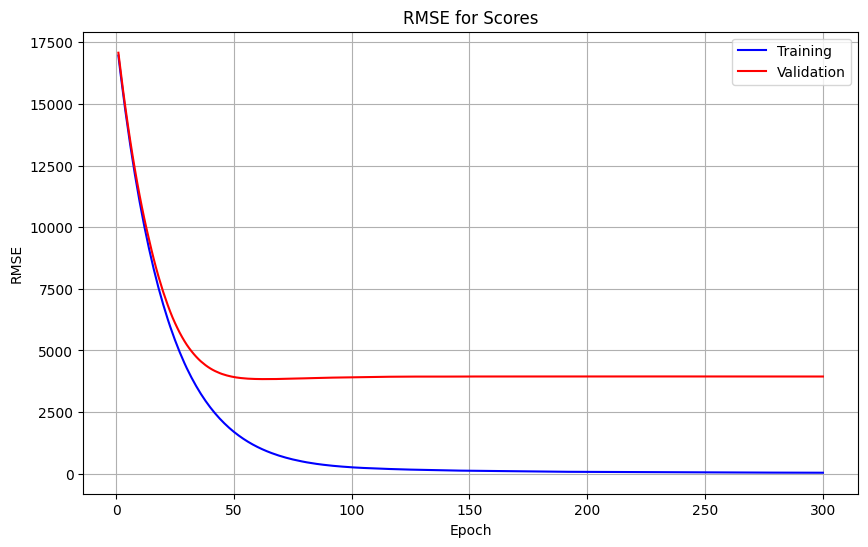

In [131]:
epochs = range(1, len(evals_result['validation_0']['rmse']) + 1)
train_rmse = evals_result['validation_0']['rmse']
test_rmse = evals_result['validation_1']['rmse']

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_rmse, label='Training', color='blue')
plt.plot(epochs, test_rmse, label='Validation', color='red')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE for Scores')
plt.legend()
plt.grid(True)
plt.show()

In [132]:
# y_pred = model.predict(X_test_selected)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error: 2126523.13
R^2 Score: 0.99


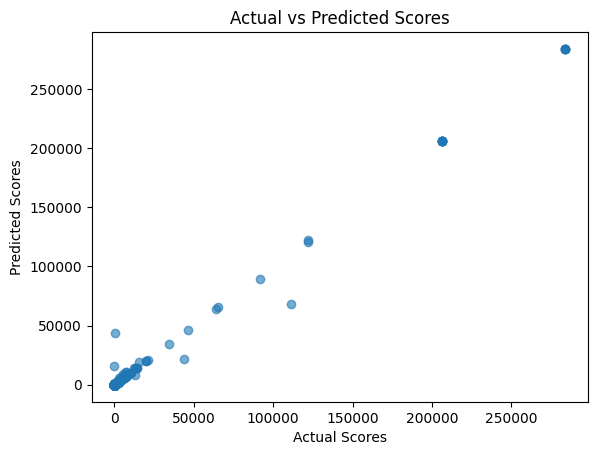

In [133]:
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual Scores")
plt.ylabel("Predicted Scores")
plt.title("Actual vs Predicted Scores")
plt.show()

#### Linear Regression for Scores

In [134]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0) 
}

for model_name, model in models.items():
    model.fit(X_train, y_train)  
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f"Model: {model_name}")
    print(f"  Train MSE: {train_mse:.4f}")
    print(f"  Test MSE: {test_mse:.4f}")
    print(f"  Train R2: {train_r2:.4f}")
    print(f"  Test R2: {test_r2:.4f}")
    print("-" * 30)

Model: Linear Regression
  Train MSE: 232129567.9444
  Test MSE: 268063874.8545
  Train R2: 0.2673
  Test R2: 0.2861
------------------------------
Model: Ridge Regression
  Train MSE: 231095862.7328
  Test MSE: 267290495.9660
  Train R2: 0.2705
  Test R2: 0.2881
------------------------------


## # of Comments

In [150]:
X_train, X_test, y_train, y_test = X_com_train, X_com_test, y_com_train, y_com_test

# Replace infinite values with NaN
X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan


# #impute nan values with mean
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [151]:
from sklearn.model_selection import GridSearchCV

param_grid = {"n_estimators": [100, 300, 500],
          "learning_rate": [0.01, 0.05, 0.1, 0.5, 1],
          "random_state": [42]
          }

model = XGBRegressor()
grid_search = GridSearchCV(model, param_grid=param_grid)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
# model.set_params(**grid_search.best_params_)

{'learning_rate': 0.01, 'n_estimators': 300, 'random_state': 42}


In [152]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.01,
    random_state=66,
    objective='reg:squarederror',
    # early_stopping_rounds=50
)

evals_result = {}
# model.fit(X_train_selected, y_train)
model.fit(X_train, y_train, 
          eval_set=[(X_train, y_train), (X_val, y_val)])
evals_result = model.evals_result()

[0]	validation_0-rmse:494.34161	validation_1-rmse:303.05881
[1]	validation_0-rmse:491.08071	validation_1-rmse:300.40773
[2]	validation_0-rmse:487.84627	validation_1-rmse:297.83053
[3]	validation_0-rmse:484.63804	validation_1-rmse:295.32741
[4]	validation_0-rmse:481.45580	validation_1-rmse:292.89860
[5]	validation_0-rmse:478.29931	validation_1-rmse:290.54423
[6]	validation_0-rmse:475.16833	validation_1-rmse:288.26449
[7]	validation_0-rmse:472.06263	validation_1-rmse:286.05894
[8]	validation_0-rmse:468.98197	validation_1-rmse:283.92875
[9]	validation_0-rmse:465.92613	validation_1-rmse:281.87291
[10]	validation_0-rmse:462.89483	validation_1-rmse:279.91619
[11]	validation_0-rmse:459.88784	validation_1-rmse:278.01000
[12]	validation_0-rmse:456.90490	validation_1-rmse:276.20282
[13]	validation_0-rmse:453.94581	validation_1-rmse:274.46984
[14]	validation_0-rmse:451.01038	validation_1-rmse:272.81206
[15]	validation_0-rmse:448.09838	validation_1-rmse:271.20419
[16]	validation_0-rmse:445.20956	v

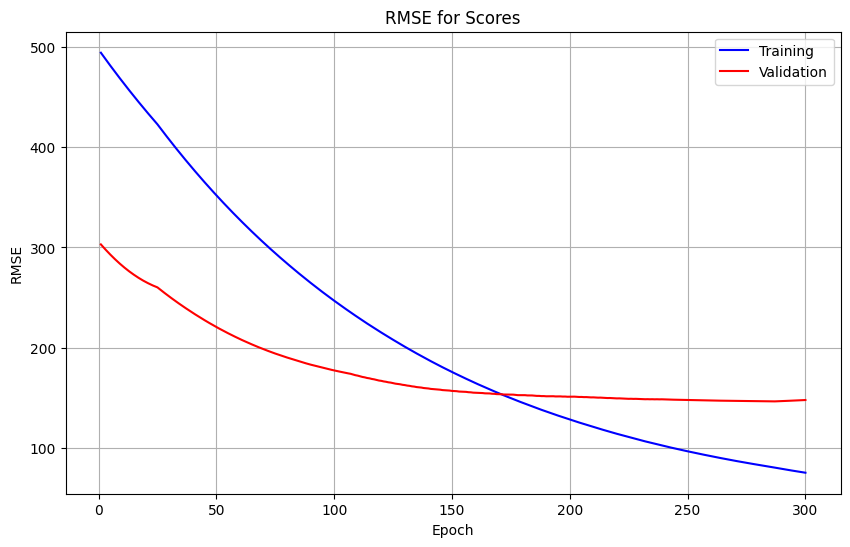

In [153]:
epochs = range(1, len(evals_result['validation_0']['rmse']) + 1)
train_rmse = evals_result['validation_0']['rmse']
test_rmse = evals_result['validation_1']['rmse']

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_rmse, label='Training', color='blue')
plt.plot(epochs, test_rmse, label='Validation', color='red')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE for Scores')
plt.legend()
plt.grid(True)
plt.show()

In [154]:
# y_pred = model.predict(X_test_selected)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error: 317091.86
R^2 Score: 0.18


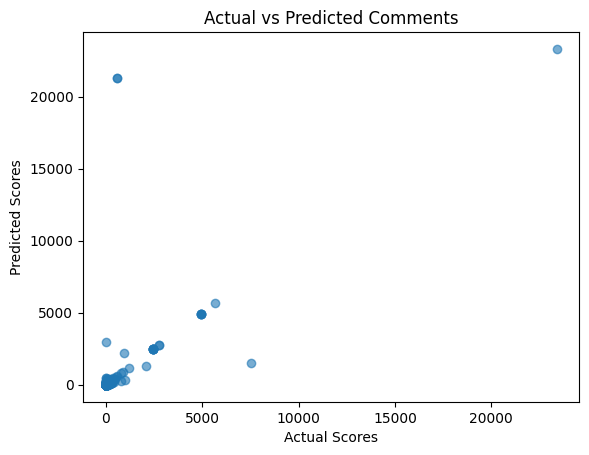

In [147]:
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual Scores")
plt.ylabel("Predicted Scores")
plt.title("Actual vs Predicted Comments")
plt.show()

#### Linear Regression for Comments

In [148]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0) 
}

for model_name, model in models.items():
    model.fit(X_train, y_train)  
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f"Model: {model_name}")
    print(f"  Train MSE: {train_mse:.4f}")
    print(f"  Test MSE: {test_mse:.4f}")
    print(f"  Train R2: {train_r2:.4f}")
    print(f"  Test R2: {test_r2:.4f}")
    print("-" * 30)

Model: Linear Regression
  Train MSE: 308096.2931
  Test MSE: 357310.3727
  Train R2: 0.0811
  Test R2: 0.0782
------------------------------
Model: Ridge Regression
  Train MSE: 308220.0765
  Test MSE: 357041.4247
  Train R2: 0.0807
  Test R2: 0.0788
------------------------------
